In [1]:
%matplotlib inline
import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

Using TensorFlow backend.


In [2]:
train = np.loadtxt('../../data/digit-recognizer/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('../../data/digit-recognizer/test.csv', delimiter=',', skiprows=1)

In [3]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

In [4]:
# Предобработаем изображения
def crop_normalize_blur(image):
    return cv2.GaussianBlur(normalize(image[3:-4, 4:-3]), (3,3), 0) 

In [5]:
# Вычисляем X и Y составляющие градиента с помощью оператора Собеля
def sobel(image):
    sobel_x = cv2.Sobel(image, cv2.CV_64F, dx=1, dy=0, ksize=3)
    sobel_y = cv2.Sobel(image, cv2.CV_64F, dx=0, dy=1, ksize=3)
    return sobel_x, sobel_y

In [6]:
def gradient_histogram(gradient, theta, number_of_bins=16):
    # Гистограммы вычисляются с учетом длины вектора градиента
    hist_columns = []
    for gradient_row, theta_row in zip(np.split(gradient, 3), np.split(theta, 3)):
        hist_row = []
        for gradient_cell, theta_cell in zip(np.split(gradient_row, 3, axis=1), np.split(theta_row, 3, axis=1)):
            hist, borders = np.histogram(
                theta_cell,
                bins=number_of_bins,
                range=(0., 2. * np.pi),
                weights=gradient_cell
            )
            hist_row.append(hist)
        hist_columns.append(hist_row)
    return np.array(hist_columns)

In [7]:
def blocks_normalize(histogram_grid):
    blocks = [
        histogram_grid[:2, :2, :],
        histogram_grid[1:, :2, :],
        histogram_grid[:2, 1:, :],
        histogram_grid[1:, 1:, :],
    ]
    features = np.stack(normalize(block.reshape(1, -1)) for block in blocks).reshape(-1)
    return features

In [8]:
def get_features(images):
    for image in images:
#         Вычисляем угол и длину вектора градиента
        gradient, theta = cv2.cartToPolar(*sobel(crop_normalize_blur(image)))
        features = blocks_normalize(gradient_histogram(gradient, theta))
        yield features

In [9]:
%%time
train_data = np.stack(get_features(train_img))

CPU times: user 39.7 s, sys: 19.8 ms, total: 39.7 s
Wall time: 39.7 s


## Выводим информацию о модели

In [10]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(260, input_dim=train_data.shape[1], activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(312, activation='relu'))
model.add(keras.layers.Dropout(0.05))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.05))
model.add(keras.layers.Dense(10, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 260)               66820     
_________________________________________________________________
batch_normalization_1 (Batch (None, 260)               1040      
_________________________________________________________________
dense_2 (Dense)              (None, 312)               81432     
_________________________________________________________________
dropout_1 (Dropout)          (None, 312)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               40064     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
Total para

## Запускаем обучение

In [17]:
from keras.utils import np_utils
y_train_labels = np_utils.to_categorical(train_label)

In [18]:
model.fit(train_data, y_train_labels, batch_size=500, epochs=20)

Epoch 1/20
42000/42000 [==============================] - 2s - loss: 0.2961 - acc: 0.9134     
Epoch 2/20
42000/42000 [==============================] - 1s - loss: 0.0745 - acc: 0.9761     
Epoch 3/20
42000/42000 [==============================] - 1s - loss: 0.0499 - acc: 0.9842     
Epoch 4/20
42000/42000 [==============================] - 1s - loss: 0.0362 - acc: 0.9882     
Epoch 5/20
42000/42000 [==============================] - 1s - loss: 0.0269 - acc: 0.9915     
Epoch 6/20
42000/42000 [==============================] - 1s - loss: 0.0208 - acc: 0.9934     
Epoch 7/20
42000/42000 [==============================] - 1s - loss: 0.0169 - acc: 0.9944     
Epoch 8/20
42000/42000 [==============================] - 1s - loss: 0.0128 - acc: 0.9960     
Epoch 9/20
42000/42000 [==============================] - 1s - loss: 0.0104 - acc: 0.9970     
Epoch 10/20
42000/42000 [==============================] - 1s - loss: 0.0082 - acc: 0.9978     
Epoch 11/20
42000/42000 [========================

# LeNet

In [46]:
lenet = keras.models.Sequential()
lenet.add(keras.layers.Conv2D(6, (5,5), padding='same', activation='relu', input_shape=(28, 28, 1)))
lenet.add(keras.layers.MaxPool2D(pool_size=(2,2), padding='valid'))
lenet.add(keras.layers.Conv2D(16, (5,5), padding='valid', activation='relu'))
lenet.add(keras.layers.MaxPool2D(pool_size=(2,2), padding='valid'))
lenet.add(keras.layers.Flatten())
lenet.add(keras.layers.Dense(120, activation='relu'))
lenet.add(keras.layers.Dense(84, activation='relu'))
lenet.add(keras.layers.noise.GaussianDropout(0.05))
lenet.add(keras.layers.Dense(10, activation='softmax'))
lenet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [47]:
lenet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 28, 28, 6)         156       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 10, 10, 16)        2416      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 120)               48120     
_________________________________________________________________
dense_28 (Dense)             (None, 84)                10164     
__________

In [48]:
lenet.fit(np.resize(train[:, 1:], (train.shape[0], 28, 28, 1)), y_train_labels, batch_size=500, epochs=20)

Epoch 1/20
42000/42000 [==============================] - 8s - loss: 2.9894 - acc: 0.7043     
Epoch 2/20
42000/42000 [==============================] - 8s - loss: 0.2202 - acc: 0.9370     
Epoch 3/20
42000/42000 [==============================] - 8s - loss: 0.1365 - acc: 0.9598     
Epoch 4/20
42000/42000 [==============================] - 8s - loss: 0.0968 - acc: 0.9704     
Epoch 5/20
42000/42000 [==============================] - 8s - loss: 0.0740 - acc: 0.9773     
Epoch 6/20
42000/42000 [==============================] - 8s - loss: 0.0556 - acc: 0.9819     
Epoch 7/20
42000/42000 [==============================] - 8s - loss: 0.0475 - acc: 0.9846     
Epoch 8/20
42000/42000 [==============================] - 8s - loss: 0.0395 - acc: 0.9865     
Epoch 9/20
42000/42000 [==============================] - 8s - loss: 0.0321 - acc: 0.9898     
Epoch 10/20
42000/42000 [==============================] - 8s - loss: 0.0257 - acc: 0.9916     
Epoch 11/20
42000/42000 [========================

## Предсказываем класс объекта

In [49]:
pred_val_model = model.predict_classes(train_data)

40672/42000 [============================>.] - ETA: 0s

In [50]:
# Your submission scored 0.98528

In [53]:
pred_val_lenet = lenet.predict_classes(np.resize(train[:, 1:], (train.shape[0], 28, 28, 1)))

41984/42000 [============================>.] - ETA: 0s

In [ ]:
# Your submission scored 0.98028

## Оцениваем качество решение на валидационной выборке

In [54]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(train_label, pred_val_model))

from sklearn.metrics import classification_report
print(classification_report(train_label, pred_val_model))

from sklearn.metrics import confusion_matrix
print(confusion_matrix(train_label, pred_val_model))

Accuracy: 0.998666666667
             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00      4132
        1.0       1.00      1.00      1.00      4684
        2.0       1.00      1.00      1.00      4177
        3.0       1.00      1.00      1.00      4351
        4.0       1.00      1.00      1.00      4072
        5.0       1.00      1.00      1.00      3795
        6.0       1.00      1.00      1.00      4137
        7.0       1.00      1.00      1.00      4401
        8.0       1.00      1.00      1.00      4063
        9.0       1.00      1.00      1.00      4188

avg / total       1.00      1.00      1.00     42000

[[4131    0    0    0    1    0    0    0    0    0]
 [   0 4677    2    0    0    0    0    4    0    1]
 [   0    0 4176    0    0    0    0    1    0    0]
 [   0    0    1 4350    0    0    0    0    0    0]
 [   0    0    0    0 4066    0    0    0    0    6]
 [   0    0    0    9    0 3786    0    0    0    0]
 [   1    0    0  

In [55]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(train_label, pred_val_lenet))

from sklearn.metrics import classification_report
print(classification_report(train_label, pred_val_lenet))

from sklearn.metrics import confusion_matrix
print(confusion_matrix(train_label, pred_val_lenet))

Accuracy: 0.998333333333
             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00      4132
        1.0       1.00      1.00      1.00      4684
        2.0       1.00      1.00      1.00      4177
        3.0       1.00      1.00      1.00      4351
        4.0       1.00      1.00      1.00      4072
        5.0       1.00      1.00      1.00      3795
        6.0       1.00      1.00      1.00      4137
        7.0       1.00      1.00      1.00      4401
        8.0       1.00      1.00      1.00      4063
        9.0       1.00      1.00      1.00      4188

avg / total       1.00      1.00      1.00     42000

[[4132    0    0    0    0    0    0    0    0    0]
 [   0 4683    0    0    0    0    0    1    0    0]
 [   0    1 4176    0    0    0    0    0    0    0]
 [   2    0    5 4344    0    0    0    0    0    0]
 [   0    1    0    1 4068    0    0    1    0    1]
 [   2    0    1    1    0 3788    1    0    2    0]
 [  15    0    1  

## Предсказания на тестовых данных

In [22]:
pred_test = model.predict_classes(np.stack(get_features(test_img)))

26880/28000 [===========================>..] - ETA: 0s

In [56]:
pred_lenet = lenet.predict_classes(np.resize(test, (test.shape[0], 28, 28, 1)))

27808/28000 [============================>.] - ETA: 0s

## Визуализируем предсказания

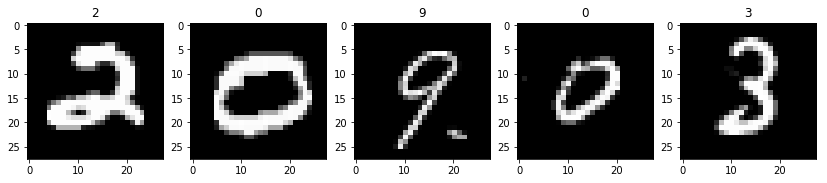

In [57]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_lenet[i - 1]);

## Готовим файл для отправки

In [58]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_lenet, 1):
        dst.write('%s,%s\n' % (i, int(p)))